Импорт необходимых библиотек:

In [2]:
import numpy as np
import matplotlib.pylab as plt
from scipy.fftpack import fft, fftfreq, ifft
from datetime import datetime, timedelta
from scipy import signal

Задание параметров обработки:

In [3]:
sample_rate         = 32000     #Hz

M1_amplifier_dB     = 26.       #dB
M3_amplifier_dB     = 32.       #dB
M1_sensitivity_dB   = -165.     #dB re 1V/µPa
M3_sensitivity_dB   = -170.     #dB re 1V/µPa

station             = 'M1'
                            # ( year, month, day, hour, min, sec, microsecond)
start_time          = datetime( 2014,     6,  24,    5,   0,   0 )
end_time            = datetime( 2014,     6,  24,    5,  10,   0 )

freq_band           = [4000, 10000] #Hz
filter_order        = 16

smooth_window_size  = 200
# как грамотно определить размер окна фильтрации ??
smooth_window       = signal.windows.tukey(smooth_window_size, alpha=0.5)

Чтение файлов и отображение сигнала:

In [4]:
duration = end_time - start_time
files_num = int(np.ceil(duration.seconds / 600))

data_array_V = np.array([0])

def file_name(station, start, end):
    return f'{station}_{start.day:02d}{start.month:02d}{start.hour:02d}{start.minute:02d}-{end.day:02d}{end.month:02d}{end.hour:02d}{end.minute:02d}.dat'

current_time = start_time

samples = np.zeros(600 * sample_rate)

data_arrays = []

for i in range(files_num):
    next_time = start_time + timedelta(minutes = 10)
    with open(file_name(station, current_time, next_time), 'r') as fID:
        samples = np.fromfile(fID, np.int16).astype(np.float32)
        data_arrays.append(samples)
    continue_time = next_time

data_array_V = np.concatenate(data_arrays)

positive_mask = data_array_V > 0
negative_mask = data_array_V < 0

constant = (M1_sensitivity_dB + M1_amplifier_dB) * (station == 'M1') + (M3_sensitivity_dB + M3_amplifier_dB) * (station == 'M3')

SPL = np.zeros_like(data_array_V)
SPL[positive_mask] = 20 * np.log10(data_array_V[positive_mask]) - constant
SPL[negative_mask] = -20 * np.log10(np.abs(data_array_V[negative_mask])) + constant

time = np.linspace(start_time, end_time, duration.seconds * sample_rate)

Signal smoothing:

In [5]:
smooth_window /= smooth_window.sum()
SPL_smoothed = np.convolve(SPL, smooth_window, 'same')
# numpy.convolve(a, v, mode='full')

Text(0, 0.5, 'SPL [dB re 1 µPa]')

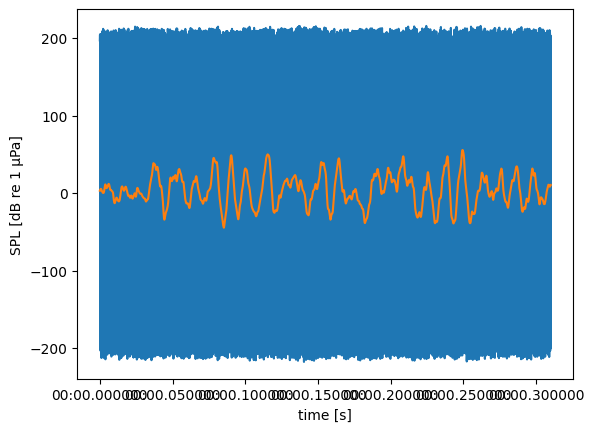

In [6]:
# сделать адекватный интерфейс выбора временного интервала
plt.plot(time[:10000], SPL[:10000])
plt.plot(time[:10000], SPL_smoothed[:10000])
plt.xlabel('time [s]')
plt.ylabel('SPL [dB re 1 µPa]')

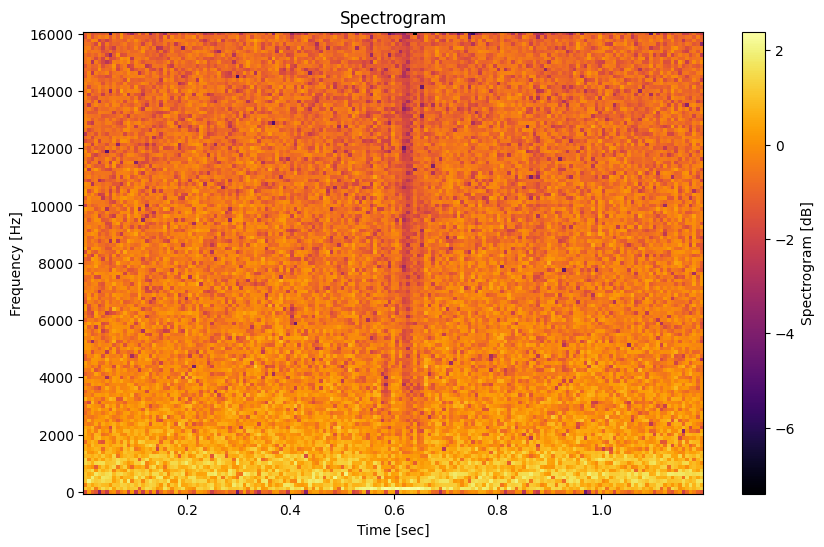

In [7]:
# нужно ли осреднять перед построением спектрограммы ??
frequencies, times, spectrogram = signal.spectrogram(SPL[3200*6*983:3200*6*985], sample_rate)
# spectrogram(x, fs=1.0, window=('tukey', 0.25), nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')

plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, np.log10(spectrogram), cmap = 'inferno')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Spectrogram [dB]')
plt.title('Spectrogram')
plt.show()

Band-pass filtering:

In [ ]:
# осреднение, потом фильтр, или фильтр, потом осреднение ??
SPL_sos = signal.butter(filter_order, freq_band, 'bandpass', fs=sample_rate, output='sos')
# butter(N, Wn, btype='low', analog=False, output='ba', fs=None) second-order sections (‘sos’)
SPL_filtered = signal.sosfiltfilt(SPL_sos, SPL)

In [ ]:
plt.plot(time[:100000], SPL[:100000])
plt.plot(time[:100000], SPL_filtered[:100000])
plt.xlabel('time [s]')
plt.ylabel('SPL [dB re 1 µPa]')
# почему изменяется амплитуда сигнала после фильтрации ??

In [ ]:
frequencies, times, spectrogram = signal.spectrogram(SPL_filtered[:100000], sample_rate)
# spectrogram(x, fs=1.0, window=('tukey', 0.25), nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')

plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, np.log10(spectrogram), cmap = 'inferno')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Spectrogram [dB]')
plt.title('Spectrogram')
plt.show()